In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import imutils
import datetime
from spellchecker import SpellChecker
from PIL import Image, ImageDraw, ImageOps
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data A.S
train_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_train_v2.csv')
test_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_test_v2.csv')
val_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_validation_v2.csv')

In [3]:
#Drop rows with missing labels A.S
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

In [4]:
# Remove unreadable images A.S
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

In [5]:
# Convert labels to uppercase A.S
train_name['IDENTITY'] = train_name['IDENTITY'].str.upper()
val_name['IDENTITY'] = val_name['IDENTITY'].str.upper()
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

In [6]:
# Reset the index A.S
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

In [7]:
def increaseImageQuality(img):
    # Check image type and convert if necessary
    if img.dtype != np.uint8:
        img = np.uint8(img / np.max(img) * 255)
    # Increase the contrast of the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpen the image
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
    
    return img

In [8]:
def preprocessImage(img):
    (h, w) = img.shape

    # Calculate the new size while preserving the aspect ratio
    max_width = 256
    max_height = 64
    aspect_ratio = float(img.shape[1]) / img.shape[0]
    new_width = int(max_height * aspect_ratio)
    new_height = max_height

    if new_width > max_width:
        new_width = max_width
        new_height = int(new_width / aspect_ratio)

    # Ensure that the new height is at least 31 pixels
    if new_height < 31:
        new_height = 31
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    if h < max_height and w < max_width:
        resized_image = img
    else:
        resized_image = imutils.resize(image, width = 256, height = 64)

    # Calculate the padding values
    top = max(0, (h - new_height) // 2)
    bottom = max(0, h - new_height - top)
    left = max(0, (w - new_width) // 2)
    right = max(0, w - new_width - left)

    # Add padding if necessary
    resized_image_with_padding = resized_image
    #resized_image_with_padding = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Create a blank white image with the final size
    final_img = np.ones([64, 256])*255 

    # Resize the padded image to fit the final size
    resized_padded_image = cv2.resize(resized_image_with_padding, (256, 64), interpolation=cv2.INTER_AREA)

    # Copy the resized padded image to the final image
    final_img[:resized_padded_image.shape[0], :resized_padded_image.shape[1]] = resized_padded_image
    final_img = increaseImageQuality(final_img)
    # Rotate the final image 90 degrees clockwise
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite('test.png',final_img)
    return final_img

In [9]:
def autocorrect(prediction):
    my_file = open("WordsDictionary.txt", "r")
    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.split("\n")
    #print(data_into_list)
    spell = SpellChecker()
    spell.word_frequency.load_words(data_into_list)
    word = spell.correction(prediction)
    word = word.upper()
    return word

In [10]:
def cropImage(im):
    # Get rid of existing black border by flood-filling with white from top-left corner
    ImageDraw.floodfill(im,xy=(0,0),value=(255,255,255),thresh=10)

    # Get bounding box of text and trim to it
    bbox = ImageOps.invert(im).getbbox()
    trimmed = im.crop(bbox)

    # Add new white border, then new black, then new white border
    res = ImageOps.expand(trimmed, border=1, fill=(255,255,255))
#     res = ImageOps.expand(res, border=5, fill=(255,255,255))
#     res = ImageOps.expand(res, border=5, fill=(255,255,255))
    res.save('result.png')
    return res

In [12]:
train_x = []
for i in range(train_size):
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = Image.open(img_dir)
    image = cropImage(image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image/255.
    train_x.append(image)

In [13]:
valid_x = []

for i in range(valid_size):
    img_dir = 'D:/WorkStation/Datasets/archive/validation_v2/validation/'+val_name.loc[i, 'FILENAME']
    image = Image.open(img_dir)
    image = cropImage(image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image/255.
    valid_x.append(image)

In [20]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [21]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank



def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [22]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])]= label_to_num(train_name.loc[i, 'IDENTITY'])  

In [23]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_name.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val_name.loc[i, 'IDENTITY'])]= label_to_num(val_name.loc[i, 'IDENTITY'])  

In [24]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [25]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [26]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [27]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001), metrics=['mean_squared_error'])

Model1 = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=32)

Epoch 1/30
938/938 [==============================] - 104s 96ms/step - loss: 21.1752 - mean_squared_error: 585.9224 - val_loss: 19.4214 - val_mean_squared_error: 424.9188
Epoch 2/30
938/938 [==============================] - 85s 90ms/step - loss: 16.6167 - mean_squared_error: 326.5964 - val_loss: 12.3268 - val_mean_squared_error: 201.2630
Epoch 3/30
938/938 [==============================] - 87s 93ms/step - loss: 8.7245 - mean_squared_error: 121.9574 - val_loss: 5.8082 - val_mean_squared_error: 71.6978
Epoch 4/30
938/938 [==============================] - 86s 92ms/step - loss: 5.4120 - mean_squared_error: 66.0006 - val_loss: 4.1346 - val_mean_squared_error: 49.6892
Epoch 5/30
938/938 [==============================] - 91s 97ms/step - loss: 4.2482 - mean_squared_error: 50.7126 - val_loss: 3.4057 - val_mean_squared_error: 41.8939
Epoch 6/30
938/938 [==============================] - 88s 94ms/step - loss: 3.5933 - mean_squared_error: 42.7662 - val_loss: 3.0089 - val_mean_squared_error: 37

In [29]:
y_true = val_name.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    #pr = autocorrect(pr)
    tr = y_true[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
Model1CahractersPredicted = correct_char*100/total_char
Model1WordsPredicted = correct*100/valid_size    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 90.60%
Correct words predicted      : 73.18%


# code for model 2

In [95]:
def preprocessModel2(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [96]:
train_x_Model2 = []
for i in range(train_size):
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessModel2(image)
    image = image/255.
    train_x_Model2.append(image)

In [97]:
valid_x_Model2 = []

for i in range(valid_size):
    img_dir = 'D:/WorkStation/Datasets/archive/validation_v2/validation/'+val_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocessModel2(image)
    image = image/255.
    valid_x_Model2.append(image)

In [98]:
input_data = Input(shape=(256, 64, 1), name='input')
inner = Conv2D(16, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(32, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)

inner = Reshape(target_shape=((64, 8*64)), name='reshape')(inner)  # Fix target shape here
inner = Dense(32, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm2')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model2 = Model(inputs=input_data, outputs=y_pred)
model2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 16)       160       
                                                                 
 batch_normalization_15 (Bat  (None, 256, 64, 16)      64        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 256, 64, 16)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 32)       4640      
                                                           

In [99]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])]= label_to_num(train_name.loc[i, 'IDENTITY'])  

In [100]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_name.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val_name.loc[i, 'IDENTITY'])]= label_to_num(val_name.loc[i, 'IDENTITY'])  

In [101]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [102]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_begin = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [103]:

train_x_Model2 = np.array(train_x_Model2).reshape(-1, 256, 64, 1)
valid_x_Model2 = np.array(valid_x_Model2).reshape(-1, 256, 64, 1)


In [106]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_begin.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001), metrics=['mean_squared_error'])

Model2  = model_begin.fit(x=[train_x_Model2, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x_Model2, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=16)

Epoch 1/30
625/625 [==============================] - 38s 54ms/step - loss: 18.2829 - mean_squared_error: 381.9107 - val_loss: 18.0762 - val_mean_squared_error: 378.5009
Epoch 2/30
625/625 [==============================] - 33s 52ms/step - loss: 17.6710 - mean_squared_error: 360.5934 - val_loss: 17.4330 - val_mean_squared_error: 356.2402
Epoch 3/30
625/625 [==============================] - 33s 53ms/step - loss: 16.9774 - mean_squared_error: 336.1553 - val_loss: 16.8358 - val_mean_squared_error: 336.1320
Epoch 4/30
625/625 [==============================] - 33s 53ms/step - loss: 16.3049 - mean_squared_error: 312.8914 - val_loss: 16.0607 - val_mean_squared_error: 308.3448
Epoch 5/30
625/625 [==============================] - 33s 53ms/step - loss: 15.5299 - mean_squared_error: 286.7811 - val_loss: 15.2897 - val_mean_squared_error: 282.8516
Epoch 6/30
625/625 [==============================] - 36s 57ms/step - loss: 14.4611 - mean_squared_error: 252.6273 - val_loss: 14.3704 - val_mean_squa

In [109]:
preds = model2.predict(valid_x_Model2)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

157/157 [==============================] - 7s 26ms/step


In [110]:
y_true = val_name.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
Model2CahractersPredicted = correct_char*100/total_char
Model2WordsPredicted = correct*100/valid_size
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 58.56%
Correct words predicted      : 34.14%


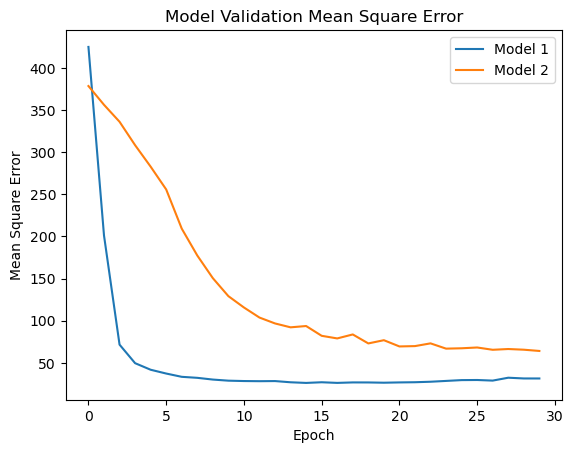

In [111]:
plt.plot(Model1.history['val_mean_squared_error'], label='Model 1')
plt.plot(Model2.history['val_mean_squared_error'], label='Model 2')
plt.title('Model Validation Mean Square Error')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend()  
plt.show()

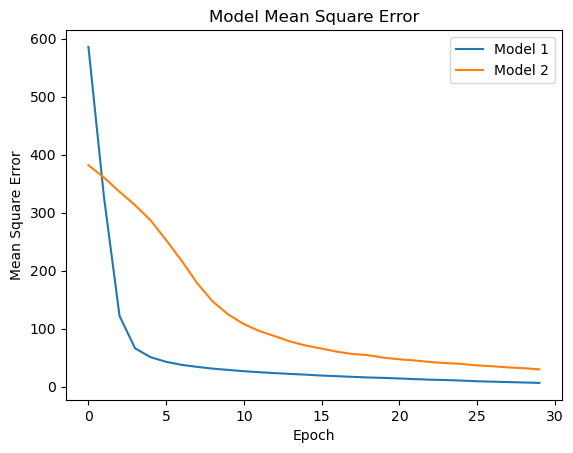

In [112]:
plt.plot(Model1.history['mean_squared_error'], label='Model 1')
plt.plot(Model2.history['mean_squared_error'], label='Model 2')
plt.title('Model Mean Square Error')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend()  
plt.show()

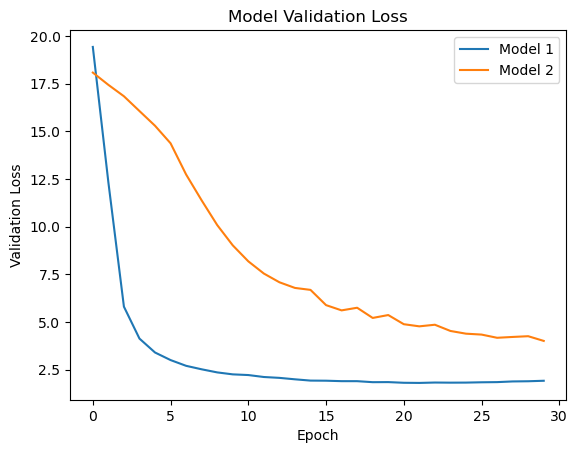

In [113]:
plt.plot(Model1.history['val_loss'], label='Model 1')
plt.plot(Model2.history['val_loss'], label='Model 2')
plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()  
plt.show()

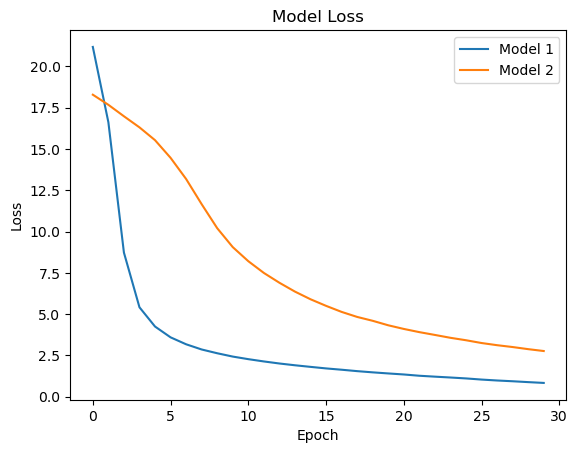

In [114]:
plt.plot(Model1.history['loss'], label='Model 1')
plt.plot(Model2.history['loss'], label='Model 2')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()  
plt.show()

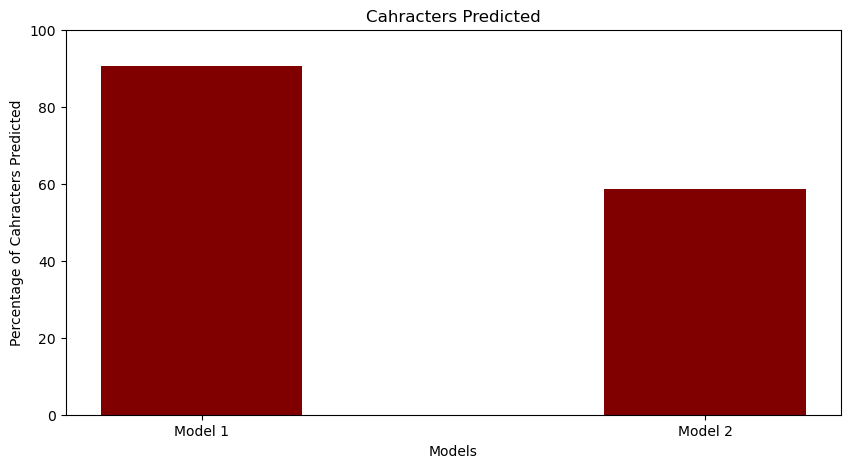

In [115]:
# creating the dataset
data = {'Model 1':Model1CahractersPredicted, 'Model 2':Model2CahractersPredicted}
Data = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Data, values, color ='Maroon',
        width = 0.4)
plt.ylim(0, 100)
plt.xlabel("Models")
plt.ylabel("Percentage of Cahracters Predicted")
plt.title("Cahracters Predicted")
plt.show()

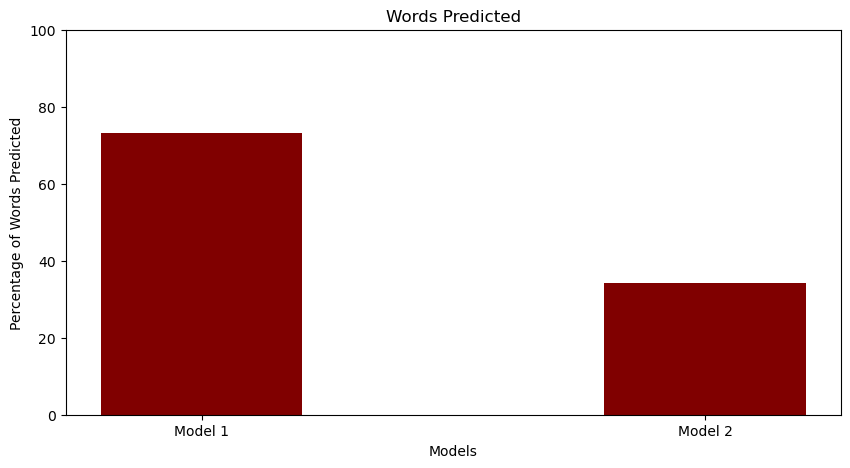

In [116]:
# creating the dataset
data = {'Model 1':Model1WordsPredicted, 'Model 2':Model2WordsPredicted}
Data = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Data, values, color ='Maroon',
        width = 0.4)
plt.ylim(0, 100)
plt.xlabel("Models")
plt.ylabel("Percentage of Words Predicted")
plt.title("Words Predicted")
plt.show()

1/1 [==============================] - 0s 124ms/step


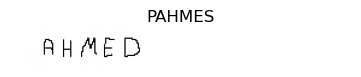

In [117]:
# Testing of Model 2
from PIL import Image, ImageDraw, ImageOps
plt.figure(figsize=(15, 10))
for i in range(1):
    ax = plt.subplot(2, 3, i+1)
#     img_dir = 'D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg'
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    #image = Image.open('D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg')
    image = cv2.imread('D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg', cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocessModel2(image)
    image = image/255.
    pred = model2.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 [==============================] - 0s 34ms/step


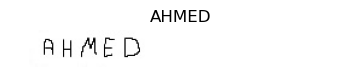

In [122]:
# Testing of Model 1
plt.figure(figsize=(15, 10))
#images = ['D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg','D:/WorkStation/Datasets/archive/test_v2/test/TEST_41300.jpg','D:/WorkStation/Datasets/archive/test_v2/test/TEST_41354.jpg']
for i in range(1):
    ax = plt.subplot(2, 3, i+1)

    image = Image.open('D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg')
    plt.imshow(image, cmap='gray')
    image = cropImage(image)
    
    
#     image = cv2.imread('result2.png', cv2.COLOR_BGR2GRAY)
#     
#     image = imutils.skeletonize(gray, size=(3, 3))
    
#     cv2.imwrite('result2.png',image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    
    image = preprocessImage(image)
    
    image = image/255.
    
    pred = model.predict(image.reshape(1, 256, 64, 1))

    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])

    predicted_word = autocorrect(num_to_label(decoded[0]))
    plt.title(predicted_word, fontsize=12)
    plt.axis('off')

    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)